In [1]:
import sklearn
from sklearn.datasets import fetch_mldata

In [2]:
mnist = fetch_mldata('MNIST original')
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

In [3]:
print(mnist.keys())

dict_keys(['DESCR', 'COL_NAMES', 'target', 'data'])


In [4]:
X,y = mnist["data"],mnist["target"]

In [5]:
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


In [6]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [7]:
idx = 36000
some_digit = X[idx]
some_digit_image = some_digit.reshape(28,28)

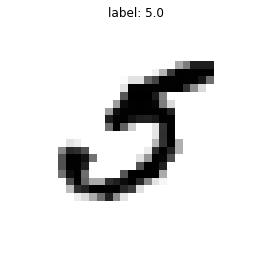

In [8]:
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,interpolation="nearest")
plt.axis("off")
plt.title("label: %s" %y[idx])
plt.show()

In [9]:
X_train,X_test,y_train,y_test = X[:60000], X[60000:],y[:60000],y[60000:]

In [10]:
import numpy as np

#### Garantindo que os dados no treinamento, sejam todos aleatorios, impedindo que algum numero fique de fora em um batch

In [11]:
shuffle_index = np.random.permutation(60000)
X_train,y_train = X_train[shuffle_index],y_train[shuffle_index]

#### Treinando um classificador binario - Simplificando para treinar apenas o numero 5

In [12]:
y_train_5 = (y_train ==5)
y_test_5 = (y_test ==5)

In [13]:
from sklearn.linear_model import SGDClassifier

In [14]:
# utiliza-se 'random_state', para conseguir resultados reproduziveis, no mais, ele é estocastico
sgd_clf = SGDClassifier (random_state = 42)
sgd_clf.fit(X_train, y_train_5)

C:\Users\Tales\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

#### Verificando se o algoritmo reconheceu o numero 5 (some_digit)

In [15]:
sgd_clf.predict([some_digit])

array([ True], dtype=bool)

### MEDIDAS DE DESEMPENHO

In [ ]:
# problema com 'StratifiedKfold', para resolver tem que instalar sklearn novamente com pip install
from sklearn.model_selection import StratifiedKfold
from sklearn.base import clone

#### Confusion Matrix

In [17]:
from sklearn.model_selection import cross_val_predict

In [18]:
y_train_pred = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3)

In [19]:
from sklearn.metrics import confusion_matrix

In [20]:
# ordenação da confusion matrix, cada linha representa classe atual, cada coluna representa classe prevista
# first row - considera non-5 images (negative class): 52453 verdadeiros negativos, 2126 falso negativos
# second row - considera 5 images (true class): 1462 falso negativos, 2959 corretos (true positives)
# | TN | FP
# | FN | TP

confusion_matrix = confusion_matrix(y_train_5,y_train_pred)
print(confusion_matrix)

[[53675   904]
 [ 1539  3882]]


In [21]:
from sklearn.metrics import precision_score, recall_score

In [22]:
# precision = TP/(TP+FP)
# == 4153 / (4153+1307)
print (confusion_matrix[1,1]/(confusion_matrix[1,1]+confusion_matrix[0,1]))
precision_score(y_train_5,y_train_pred)

0.811115754283


0.81111575428332638

In [23]:
#recall = TP/(TP+FN)
print(confusion_matrix[1,1]/(confusion_matrix[1,1]+confusion_matrix[1,0]))
recall_score(y_train_5,y_train_pred)

0.716104039845


0.716104039845047

In [24]:
from sklearn.metrics import f1_score
f1_score(y_train_5,y_train_pred)

0.76065445282649158

#### Looking for predictions using any threshold

In [25]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([ 147539.68314071])

In [26]:
threshold = 0
y_some_digit_pred = (y_scores>threshold)
y_some_digit_pred

array([ True], dtype=bool)

In [27]:
threshold = 200000
y_some_digit_pred = (y_scores>threshold)
y_some_digit_pred

array([False], dtype=bool)

In [28]:
y_scores = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3,method="decision_function")
y_scores.shape

(60000, 2)

In [29]:
from sklearn.metrics import precision_recall_curve

In [ ]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5,y_scores)

In [ ]:
def plot_precision_recall_vs_threshold(precisions,recalls,thresholds):
    plt.plot(thresholds,precisions[:-1],"b--",label="Precision")
    plt.plot(thresholds,recalls[:-1],"g-",label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.ylim([0,1])

In [ ]:
plot_precision_recall_vs_threshold(precisions,recalls,thresholds)
plt.show()

#### Multilabel Classification

In [30]:
from sklearn.neighbors import KNeighborsClassifier

In [31]:
# criamos dois labels output --- 1st indica quais algoritmos são maiores que 7, e 2nd indica quais são impares
y_train_large = (y_train >=7)
y_train_odd = (y_train%2 ==1)
y_multilabel = np.c_[y_train_large,y_train_odd]

In [32]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train,y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [75]:
print(X_train.shape)
print(y_multilabel.shape)

(60000, 784)
(60000, 2)


In [33]:
some_digit.shape

(784,)

In [34]:
# predict o numero 5, que não é maior que 7, mas é impar
knn_clf.predict([some_digit])

array([[False,  True]], dtype=bool)

In [ ]:
# measure the F1 score for each individual label, then simply compute the average score
y_train_knn_pred = cross_val_predict(knn_clf,X_train, y_multilabel, cv=3)
f1_score(y_multilabel,y_train_knn_pred, average="macro")

#### Multioutput Classification

In [67]:
noise = np.random.randint(0,100,(len(X_train),784))
X_train_mod = X_train+noise
noise = np.random.randint(0,100,(len(X_test),784))
X_test_mod = X_test+noise
y_train_mod = X_train
y_test_mod = X_test

In [68]:
X_test_mod.shape

(10000, 784)

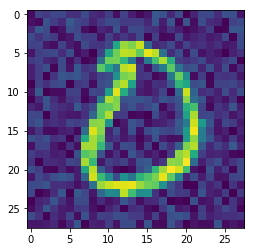

In [73]:
teste = X_test_mod[55,:]
plt.imshow(np.reshape(teste,[28,28]))
plt.show()

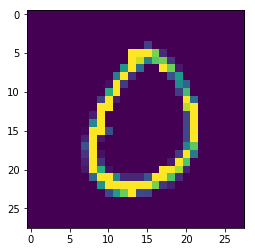

In [59]:
knn_clf.fit(X_train_mod,y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[55]])
plt.imshow(np.reshape(clean_digit,[28,28]))
plt.show()

In [76]:
print(X_train_mod.shape)
print(y_train_mod.shape)
clean_digit.shape

(60000, 784)
(60000, 784)


(1, 784)